In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from explainability_metrics import compute_shapley_values, compute_permutation_importance, plot_shapley_values_comparison, plot_permutation_importance_comparison

/home/pablo/Scrivania/Progetti/global/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("compas_from_aif360.csv")

# Mostra il contenuto
print(df)

      sex   age  race  juv_fel_count  juv_misd_count  juv_other_count  \
0     0.0  69.0   0.0            0.0             0.0              0.0   
1     0.0  34.0   0.0            0.0             0.0              0.0   
2     0.0  24.0   0.0            0.0             0.0              1.0   
3     0.0  44.0   0.0            0.0             0.0              0.0   
4     0.0  41.0   1.0            0.0             0.0              0.0   
...   ...   ...   ...            ...             ...              ...   
6162  0.0  23.0   0.0            0.0             0.0              0.0   
6163  0.0  23.0   0.0            0.0             0.0              0.0   
6164  0.0  57.0   0.0            0.0             0.0              0.0   
6165  1.0  33.0   0.0            0.0             0.0              0.0   
6166  1.0  23.0   0.0            0.0             0.0              0.0   

      priors_count  age_cat=25 - 45  age_cat=Greater than 45  \
0              0.0              0.0                      1.

In [3]:
X = df.iloc[:, :-1]  # Tutte le colonne tranne l'ultima (401 features)
y = df.iloc[:, -1]   # Ultima colonna (target binario)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Standardizza le features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

#pca = PCA(n_components=15)
#X_reduced = pca.fit_transform(X_scaled)

# Dividi in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Features shape: (6167, 401)
Target shape: (6167,)
Training set: 4316 samples
Test set: 1851 samples


In [4]:
from quantum_kernel import qkernel
from sklearn.svm import SVC
from performance_metrics import print_performance_metrics
from fairness_metrics import fairness_check
import numpy as np

CLASSICAL SVM

In [5]:
print("Training classical SVM")

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Usa la funzione importata per stampare le metriche
print_performance_metrics(y_test, y_pred, title="RISULTATI CLASSICAL SVM")

Training classical SVM

RISULTATI CLASSICAL SVM
Accuracy:  0.6759
Precision: 0.6957
Recall:    0.5125
F1-Score:  0.5902

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73      1008
         1.0       0.70      0.51      0.59       843

    accuracy                           0.68      1851
   macro avg       0.68      0.66      0.66      1851
weighted avg       0.68      0.68      0.67      1851



In [6]:
test_race = X_test['race'].values
test_sex = X_test['sex'].values
test_age = X_test['age'].values

print(f"✅ Dati demografici estratti per {len(test_race)} campioni del test set")
print(f"📊 Distribuzione razza: {np.bincount(test_race.astype(int))}")
print(f"👥 Distribuzione sesso: {np.bincount(test_sex.astype(int))}")

✅ Dati demografici estratti per 1851 campioni del test set
📊 Distribuzione razza: [1219  632]
👥 Distribuzione sesso: [1498  353]


🔍 FAIRNESS METRICS

📊 RACE:
   Statistical Parity Diff: +0.216 ❌
   Equal Opportunity Diff:  +0.280 ❌
   Disparate Impact Ratio:  0.472 ❌
   Average Odds Diff:       +0.195 ⚠️

📊 SEX:
   Statistical Parity Diff: +0.173 ⚠️
   Equal Opportunity Diff:  +0.158 ⚠️
   Disparate Impact Ratio:  0.530 ❌
   Average Odds Diff:       +0.140 ⚠️

💡 SUMMARY:
   ❌ race: Biased (0/4)
   ❌ sex: Biased (0/4)

🎯 Overall: 0.0% fair


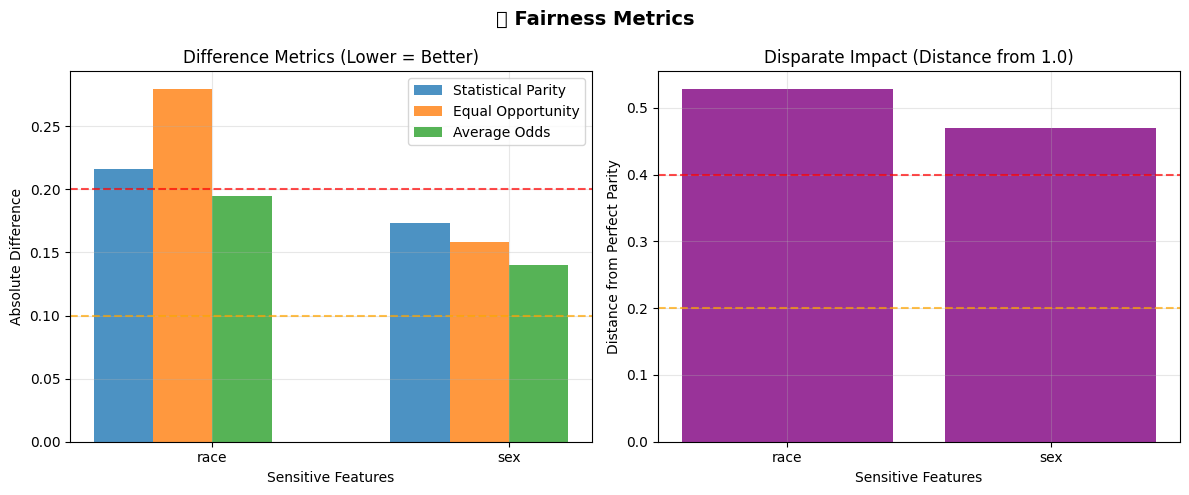

{'race': {'statistical_parity_diff': np.float64(0.21631395312613574),
  'equal_opportunity_diff': np.float64(0.27953980099502485),
  'disparate_impact': np.float64(0.4715697217219249),
  'average_odds_diff': np.float64(0.19508066116541595)},
 'sex': {'statistical_parity_diff': np.float64(0.1730238996660325),
  'equal_opportunity_diff': np.float64(0.15836009325649936),
  'disparate_impact': np.float64(0.5304532577903683),
  'average_odds_diff': np.float64(0.14013674943249566)}}

In [7]:
print("="*40)
fairness_check(y_test, y_pred, {'race': test_race, 'sex': test_sex})

QUANTUM SVM

In [8]:
# Training Quantum SVM
print("Training Quantum SVM...")

svm_quantum = SVC(kernel=qkernel, probability=True)
svm_quantum.fit(X_train.values, y_train)

Training Quantum SVM...


SVC(kernel=<function qkernel at 0x777b88667b00>, probability=True)

In [9]:
y_pred = svm_quantum.predict(X_test.values)
print_performance_metrics(y_test, y_pred, title="QUANTUM SVM")


QUANTUM SVM
Accuracy:  0.6704
Precision: 0.7122
Recall:    0.4638
F1-Score:  0.5618

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.65      0.84      0.74      1008
         1.0       0.71      0.46      0.56       843

    accuracy                           0.67      1851
   macro avg       0.68      0.65      0.65      1851
weighted avg       0.68      0.67      0.66      1851



🔍 FAIRNESS METRICS

📊 RACE:
   Statistical Parity Diff: +0.193 ⚠️
   Equal Opportunity Diff:  +0.241 ❌
   Disparate Impact Ratio:  0.467 ❌
   Average Odds Diff:       +0.171 ⚠️

📊 SEX:
   Statistical Parity Diff: +0.149 ⚠️
   Equal Opportunity Diff:  +0.175 ⚠️
   Disparate Impact Ratio:  0.540 ❌
   Average Odds Diff:       +0.126 ⚠️

💡 SUMMARY:
   ❌ race: Biased (0/4)
   ❌ sex: Biased (0/4)

🎯 Overall: 0.0% fair


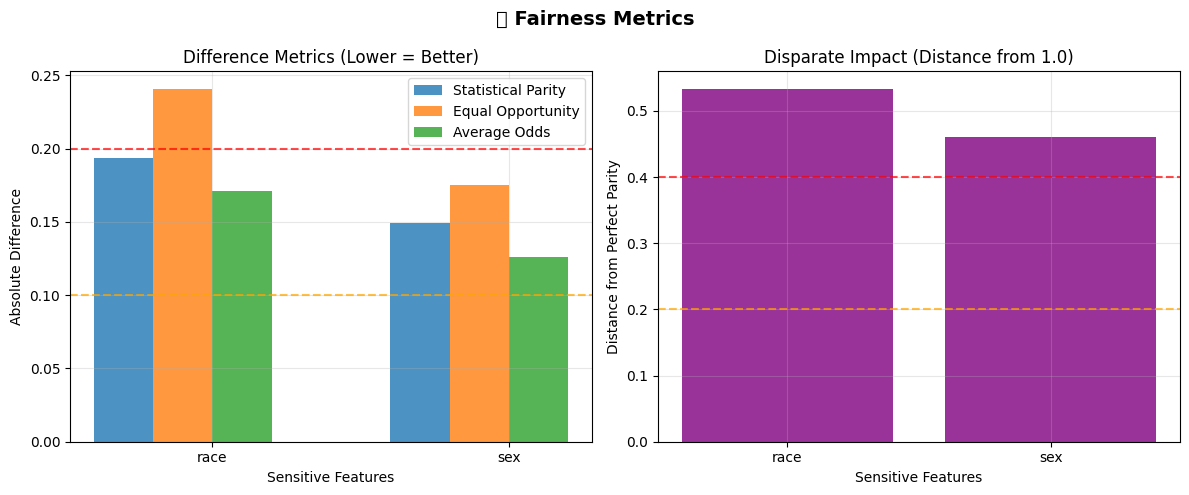

{'race': {'statistical_parity_diff': np.float64(0.19328849129292533),
  'equal_opportunity_diff': np.float64(0.24067164179104478),
  'disparate_impact': np.float64(0.46692608396815394),
  'average_odds_diff': np.float64(0.1713562290587877)},
 'sex': {'statistical_parity_diff': np.float64(0.1494627397436431),
  'equal_opportunity_diff': np.float64(0.17526283376589102),
  'disparate_impact': np.float64(0.5402562954086707),
  'average_odds_diff': np.float64(0.12591537225039454)}}

In [10]:
print("="*40)
fairness_check(y_test, y_pred, {'race': test_race, 'sex': test_sex})

EXPLAINABILITY

In [11]:
# Estrazione nomi features (tutte le colonne tranne l'ultima)
feature_names = df.columns[:-1].tolist()

print(f"✅ Estratti {len(feature_names)} nomi di features")
print(f"📊 Prime 5 features: {feature_names[:5]}")
print(f"📊 Ultime 5 features: {feature_names[-5:]}")

# Verifica che corrispondano alle dimensioni di X
print(f"🔍 Verifica: X ha {X.shape[1]} features, nomi estratti: {len(feature_names)}")

✅ Estratti 401 nomi di features
📊 Prime 5 features: ['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count']
📊 Ultime 5 features: ['c_charge_desc=Violation License Restrictions', 'c_charge_desc=Violation Of Boater Safety Id', 'c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking', 'c_charge_desc=Voyeurism', 'c_charge_desc=arrest case no charge']
🔍 Verifica: X ha 401 features, nomi estratti: 401


In [12]:
print("Shapley values classical model...")

c_shap = compute_shapley_values(svm, X_test)

Shapley values classical model...


100%|██████████| 20/20 [14:30<00:00, 43.53s/it]


In [13]:
print("Shapley values quantum model...")

q_shap = compute_shapley_values(svm_quantum, X_test)

Shapley values quantum model...


100%|██████████| 20/20 [26:32<00:00, 79.65s/it]


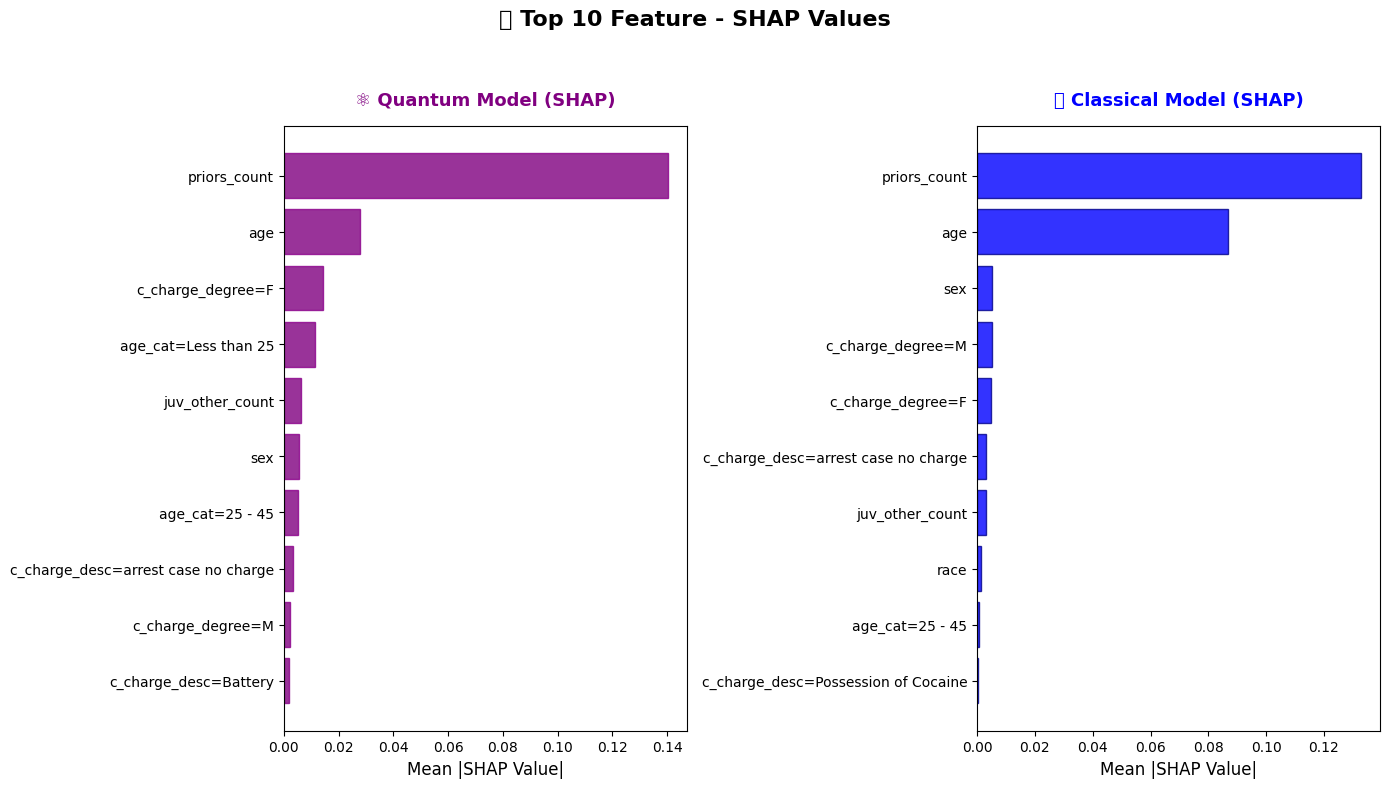

In [14]:
plot_shapley_values_comparison(q_shap, c_shap, feature_names)

In [15]:
print("Permutation importance classical model...")

classical_results = compute_permutation_importance(svm, X_test, y_test, feature_names)

Permutation importance classical model...
   Calcolo permutation importance su 50 campioni...


In [16]:
print("Permutation importance quantum model...")

quantum_results = compute_permutation_importance(svm_quantum, X_test.values, y_test, feature_names)

Permutation importance quantum model...


KeyError: '[1677, 1453, 952, 1096, 1267, 147, 1729, 310, 208, 1365, 1443, 1121, 1079, 448, 1430, 345, 0, 1098, 1402, 1335, 186, 1126, 1665, 311, 338, 560, 1340, 1077, 599, 1772, 893, 91, 492, 986, 1519] not in index'

In [ ]:
plot_permutation_importance_comparison(quantum_results, classical_results)